In [1]:
import preprocessing_utils as pu
import eda_model_utils as emu
import pickle

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# pd.set_option("display.max_rows", 300)
pd.set_option("max_colwidth", 200)

%load_ext autoreload
%autoreload 2

In [2]:
df_videos_cleaned_v7 = pickle.load(open('../Data/df_videos_cleaned_v7.pickle', 'rb'))

### Remove custom stopwords

In [3]:
df_videos_cleaned_v8 = pu.remove_custom_stopwords(df_videos_cleaned_v7)

### Video transcript word embeddings and frequency

#### Wordcloud

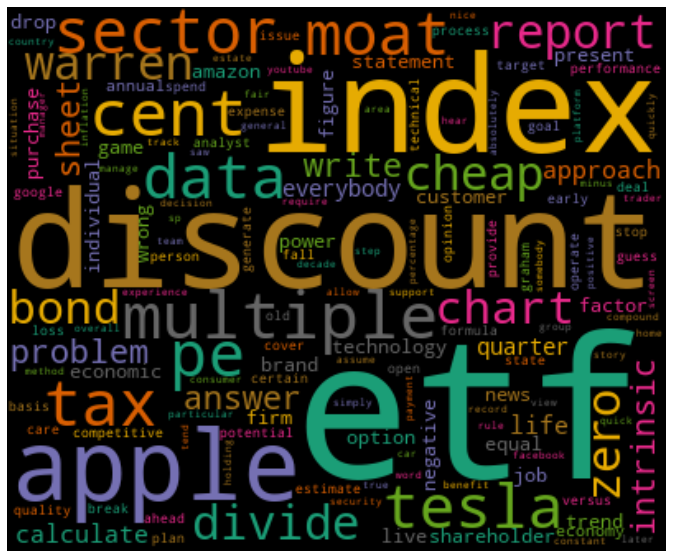

In [4]:
emu.wordcloud(df_videos_cleaned_v8, 'Transcript')

#### Visualizing Word2Vec Word Embeddings using t-SNE

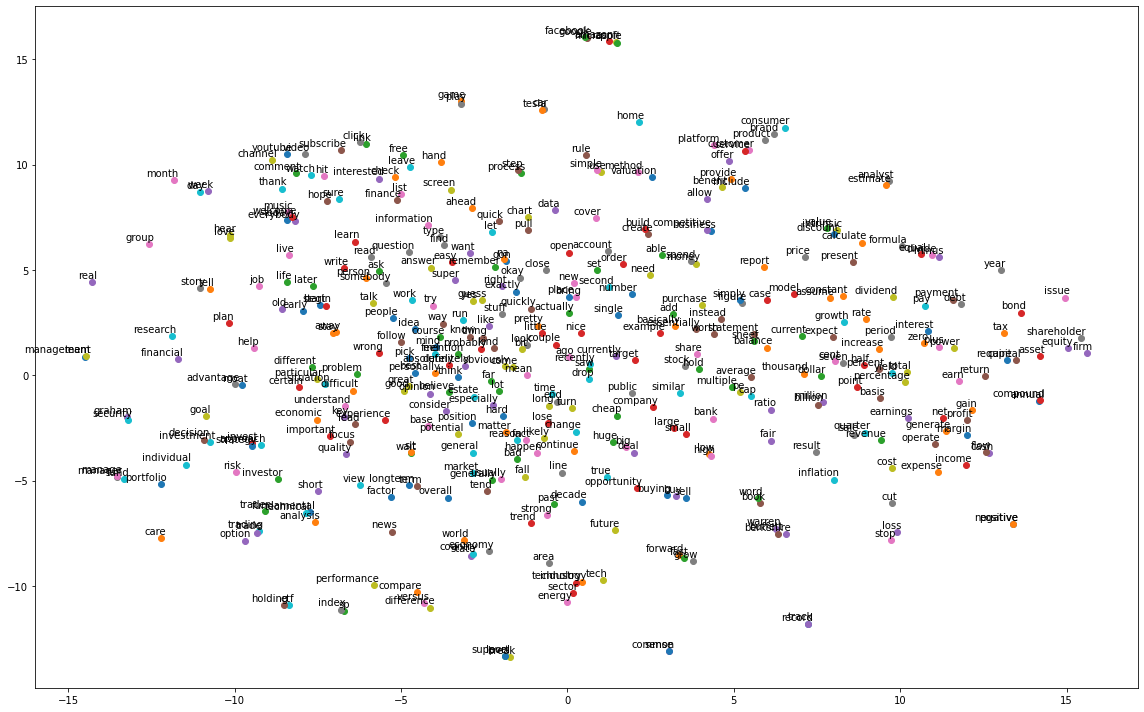

In [5]:
emu.word2vec_plot(df_videos_cleaned_v8, 'Transcript', 900, 5)

In [6]:
emu.word2vec_most_similar(df_videos_cleaned_v8, 'Transcript', 900, 5, 'technical')

[('fundamental', 0.8118055462837219),
 ('trader', 0.7759881019592285),
 ('trading', 0.7725242972373962),
 ('chart', 0.7513250112533569),
 ('analysis', 0.7493206858634949),
 ('short', 0.6937588453292847),
 ('trade', 0.6358941793441772),
 ('break', 0.5435784459114075),
 ('investor', 0.5295384526252747),
 ('level', 0.5245907306671143)]

#### Identifying bad quality videos with keyword frequency

In [7]:
df_matrix_transcript = emu.document_term_matrix_df(df_videos_cleaned_v8, 'Transcript', CountVectorizer)

In [8]:
bad_videos_1 = df_matrix_transcript[
                         (df_matrix_transcript['support']>=1) 
                       & (df_matrix_transcript['resistance']>=1)
                        ].sort_values('resistance', ascending=False)

transcript_technical = emu.bad_videos(df_videos_cleaned_v8, bad_videos_1).drop([605, 915, 245])[:40]

#### Sentiment analysis

In [9]:
transcript_technical_sent = emu.sentiment_analysis(transcript_technical, 'Transcript')

In [10]:
transcript_technical_pos = transcript_technical_sent[transcript_technical_sent['Sentiment Score']>0.9]

In [11]:
transcript_technical_pos.loc[[198, 1334, 295, 148, 201], ['Title']]

Title
198           Technical Analysis Secrets: What Most Trading Gurus Will Never Tell You (by Rayner Teo)
1334         Technically Speaking: Trading the Trend (Weeks to Months) | Long-Term Investing | 4-4-19
295   Finding Stocks on Sale | Weighing the Competition: Look for Moats | Michael Fairbourn | 5-21-19
148    ðŸš¨ðŸš€ HUGE TESLA Stock Price Prediction!! Fundamental and Technical Analysis on Tesla Stock #TSLA
201                   MARA Stock WILL 10X Your Money! | MARA Stock Technical And Fundamental Analysis

### Video title word embeddings and frequency

#### Visualizing Word2Vec Word Embeddings using t-SNE

In [12]:
df_videos_cleaned_v8_title = pu.title_preprocessing(df_videos_cleaned_v8)

In [13]:
# emu.word2vec_plot(df_videos_cleaned_v8_title, 'Title', 10, 10)

In [14]:
emu.word2vec_most_similar(df_videos_cleaned_v8_title, 'Title', 10, 5, 'programming')

[('equity', 0.9994397163391113),
 ('economic', 0.9994140863418579),
 ('ep', 0.999413013458252),
 ('stock', 0.9994013905525208),
 ('investing', 0.999398946762085),
 ('dividend', 0.9993979930877686),
 ('market', 0.9993655681610107),
 ('value', 0.9993583559989929),
 ('prediction', 0.9993578195571899),
 ('fundamental', 0.9993534088134766)]

#### Identifying bad quality videos with keyword frequency

In [15]:
df_matrix_title = emu.document_term_matrix_df(df_videos_cleaned_v8_title, 'Title', CountVectorizer)

In [16]:
bad_videos_2 = df_matrix_title[(df_matrix_title['programming']>=1)]
bad_videos_3 = df_matrix_title[(df_matrix_title['python']>=1)]
bad_videos_4 = df_matrix_title[(df_matrix_title['app']>=1)]

In [17]:
title_programming = emu.bad_videos(df_videos_cleaned_v8_title, bad_videos_2)
title_python = emu.bad_videos(df_videos_cleaned_v8_title, bad_videos_3)
title_app = emu.bad_videos(df_videos_cleaned_v8_title, bad_videos_4)

### Filtering out the bad quality videos

In [18]:
rows_to_drop = pd.concat([title_programming, title_python, title_app, transcript_technical_pos.drop('Sentiment Score', axis=1)]
                        ).drop_duplicates(subset='Video_ID').index

df_videos_cleaned_v9 = df_videos_cleaned_v8.drop(rows_to_drop).reset_index(drop=True)

In [19]:
with open('../Data/df_videos_cleaned_v9.pickle', 'wb') as f_video_data:
        pickle.dump(df_videos_cleaned_v9, f_video_data)

### Creating document-term matrices

#### CountVectorizer

In [20]:
X_cv = emu.document_term_matrix(df_videos_cleaned_v9, CountVectorizer)[0]

#### TfidfVectorizer

In [21]:
X_tfidf = emu.document_term_matrix(df_videos_cleaned_v9, TfidfVectorizer)[0]

In [22]:
with open('../Data/X_tfidf.pickle', 'wb') as f_doc_matrix:
        pickle.dump(X_tfidf, f_doc_matrix)

### Topic modeling - Entire corpus

#### Non-negative matrix factorization (NMF), CountVectorizer

In [23]:
topics_nmf_cv = emu.topic_model(X_cv, NMF, 12, 7)[0]
topics_nmf_cv

[['life', 'team', 'cheap', 'stuff', 'problem', 'answer', 'berkshire'],
 ['option', 'leap', 'decay', 'cover', 'spread', 'view', 'ge'],
 ['equal', 'divide', 'constant', 'discount', 'present', 'zero', 'minus'],
 ['graham', 'security', 'ben', 'street', 'intrinsic', 'wall', 'benjamin'],
 ['etf', 'holding', 'index', 'sector', 'expense', 'vanguard', 'individual'],
 ['bank', 'loan', 'credit', 'sector', 'percentage', 'loss', 'deposit'],
 ['unit', 'purchase', 'method', 'inventory', 'batch', 'system', 'blue'],
 ['moat', 'brand', 'customer', 'competitive', 'network', 'economic', 'mode'],
 ['tesla', 'apple', 'stuff', 'youtube', 'car', 'amazon', 'drop'],
 ['multiple', 'ebitda', 'pe', 'enterprise', 'statement', 'sheet', 'forecast'],
 ['report', 'news', 'release', 'economy', 'data', 'event', 'economic'],
 ['tax', 'roth', 'ira', 'retire', 'live', 'estate', 'goal']]

#### Non-negative matrix factorization (NMF), TfidfVectorizer

In [24]:
topics_nmf_tfidf = emu.topic_model(X_tfidf, NMF, 12, 7)[0]
topics_nmf_tfidf

[['index', 'bank', 'cheap', 'warren', 'manager', 'life', 'problem'],
 ['constant', 'formula', 'equal', 'divide', 'present', 'minus', 'calculate'],
 ['moat', 'mode', 'competitive', 'economic', 'competitor', 'brand', 'castle'],
 ['etf', 'index', 'vanguard', 'etfs', 'holding', 'expense', 'sector'],
 ['ebitda', 'enterprise', 'multiple', 'irr', 'da', 'forecast', 'decade'],
 ['apple', 'facebook', 'iphone', 'amazon', 'microsoft', 'google', 'cent'],
 ['foreign', 'applause', 'raider', 'backbone', 'nifty', 'twice', 'prior'],
 ['pe', 'eps', 'divide', 'peg', 'multiple', 'amazon', 'metric'],
 ['technical', 'trader', 'chart', 'trend', 'volume', 'statement', 'shortterm'],
 ['tesla', 'car', 'vehicle', 'elon', 'battery', 'neo', 'electric'],
 ['intrinsic',
  'discount',
  'method',
  'calculate',
  'graham',
  'safety',
  'estimate'],
 ['tax', 'johnson', 'goal', 'holding', 'roth', 'estate', 'retire']]

#### Latent Dirichlet Allocation (LDA), CountVectorizer

In [25]:
topics_lda_cv = emu.topic_model(X_cv, LatentDirichletAllocation, 12, 7)[0]
topics_lda_cv

[['bank', 'unit', 'rupee', 'purchase', 'india', 'loan', 'method'],
 ['discount', 'divide', 'calculate', 'pe', 'equal', 'formula', 'multiple'],
 ['apple', 'customer', 'amazon', 'game', 'platform', 'quarter', 'china'],
 ['etf', 'sector', 'index', 'cent', 'list', 'drop', 'chart'],
 ['moat',
  'competitive',
  'brand',
  'mode',
  'economic',
  'competitor',
  'customer'],
 ['graham', 'option', 'warren', 'berkshire', 'bank', 'security', 'safety'],
 ['tesla', 'team', 'client', 'car', 'technology', 'process', 'public'],
 ['person', 'car', 'team', 'sport', 'care', 'tax', 'trader'],
 ['index', 'sp', 'factor', 'outperform', 'oil', 'mutual', 'sector'],
 ['technical', 'report', 'trader', 'news', 'economy', 'trend', 'inflation'],
 ['tax', 'goal', 'holding', 'retire', 'johnson', 'allocation', 'expense'],
 ['stuff', 'cheap', 'life', 'everybody', 'write', 'wrong', 'answer']]

### Topic modeling - Adjectives

In [26]:
df_videos_cleaned_v9_adj = df_videos_cleaned_v9.copy()

In [27]:
df_videos_cleaned_adj = emu.corpus_of_adjectives(df_videos_cleaned_v9_adj)

In [28]:
X_cv_adj = emu.document_term_matrix(df_videos_cleaned_adj, CountVectorizer)[0]

In [29]:
X_tfidf_adj = emu.document_term_matrix(df_videos_cleaned_adj, TfidfVectorizer)[0]

#### Non-negative matrix factorization (NMF), CountVectorizer

In [30]:
topics_nmf_cv_adj = emu.topic_model(X_cv_adj, NMF, 6, 6)[0]
topics_nmf_cv_adj

[['brown', 'baer', 'beer', 'allottee', 'card', 'airfare'],
 ['brought',
  'breadandbutter',
  'burry',
  'airfare',
  'cannibalization',
  'caloric'],
 ['ama', 'candidly', 'brennan', 'breadandbutter', 'acl', 'alliance'],
 ['boxed', 'aisle', 'breadandbutter', 'bravo', 'bulb', 'booker'],
 ['arrows', 'alliance', 'attached', 'candidly', 'cannibalization', 'behave'],
 ['bestseller', 'candidly', 'assumption', 'alumni', 'alexandria', 'commingle']]

#### Non-negative matrix factorization (NMF), TfidfVectorizer

In [31]:
topics_nmf_tfidf_adj = emu.topic_model(X_tfidf_adj, NMF, 6, 6)[0]
topics_nmf_tfidf_adj

[['beer', 'brown', 'brought', 'br', 'aisle', 'burt'],
 ['ama', 'candidly', 'arrows', 'brought', 'alliance', 'canadianbased'],
 ['bestseller',
  'assumption',
  'commingle',
  'candidly',
  'alumni',
  'complimentary'],
 ['allottee', 'arcanum', 'cobit', 'contrary', 'bennett', 'aqui'],
 ['cohort', 'adorable', 'age', 'burry', 'audrey', 'airfare'],
 ['breadandbutter', 'boxed', 'bravo', 'bulb', 'caloric', 'acl']]

#### Latent Dirichlet Allocation (LDA), CountVectorizer

In [32]:
topics_lda_cv_adj = emu.topic_model(X_cv_adj, LatentDirichletAllocation, 6, 6)[0]
topics_lda_cv_adj

[['arrows', 'bestseller', 'candidly', 'brought', 'ama', 'breadandbutter'],
 ['brought', 'breadandbutter', 'airfare', 'bsc', 'card', 'audrey'],
 ['beer', 'bull', 'burton', 'brown', 'blank', 'brought'],
 ['bravo', 'boxed', 'br', 'caloric', 'breadandbutter', 'bulb'],
 ['allottee', 'arcanum', 'ax', 'cobit', 'cam', 'contrary'],
 ['aisle', 'cohort', 'convey', 'baer', 'boxed', 'christmas']]

### Assign topics and coefficients to videos

In [33]:
df_videos_cleaned_v10 = emu.topic_assignment(df_videos_cleaned_v9)

In [34]:
df_videos_cleaned_v10['Topic'].value_counts()

Value Investing                       745
Dividend Investing                    212
Technology Stocks                     173
Economic Moats                        129
Passive Investing                     121
Valuation                             113
Fundamental vs. Technical Analysis    112
Electric Vehicle Stocks                84
Valuation (Case Studies)               64
General                                25
Name: Topic, dtype: int64

### Reassign topics for videos under 'Value Investing'

In [35]:
df_videos_cleaned_v10.loc[126, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[140, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[143, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[155, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[170, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[205, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[207, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[209, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[391, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[421, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[882, 'Topic'] = 'Value Investing'	
df_videos_cleaned_v10.loc[1053, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1227, 'Topic'] = 'Value Investing'	
df_videos_cleaned_v10.loc[597, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1321, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1415, 'Topic'] = 'Value Investing'

df_videos_cleaned_v10.loc[7, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[15, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[23, 'Topic'] = 'Value Investing'                                        
df_videos_cleaned_v10.loc[27, 'Topic'] = 'Value Investing'               
df_videos_cleaned_v10.loc[28, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[29, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[31, 'Topic'] = 'Value Investing' 
df_videos_cleaned_v10.loc[32, 'Topic'] = 'Value Investing' 
df_videos_cleaned_v10.loc[36, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[39, 'Topic'] = 'Value Investing'  
df_videos_cleaned_v10.loc[40, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[42, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[44, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[46, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[49, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[53, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[59, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[62, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[65, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[70, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[75, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[84, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[85, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[88, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[93, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[95, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[107, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[108, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[111, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[116, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[118, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[120, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[121, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[123, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[132, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[142, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[162, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[163, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[167, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[181, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[189, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[190, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[199, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[200, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[210, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[212, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[213, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[345, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[361, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[371, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[398, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[419, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[432, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[437, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[473, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[484, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[494, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[495, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[498, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[506, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[526, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[553, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[554, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[564, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[572, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[582, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[587, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[593, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[596, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[615, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[616, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[617, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[623, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[625, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[628, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[653, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[659, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[661, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[666, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[697, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[733, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[738, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[742, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[754, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[755, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[786, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[798, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[799, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[801, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[818, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[830, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[856, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[858, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[867, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[869, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[880, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[897, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[915, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[918, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[926, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[935, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[941, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[954, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[977, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1007, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1012, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1018, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1020, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1030, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1031, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1032, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1038, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1041, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1043, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1046, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1054, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1056, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1058, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1078, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1079, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1082, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1116, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1120, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1124, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1125, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1136, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1142, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1163, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1172, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1176, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1177, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1181, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1197, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1201, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1209, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1229, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1258, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1266, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1267, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1271, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1275, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1280, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1287, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1292, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1303, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1306, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1308, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1318, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1329, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1335, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1354, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1356, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1390, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1394, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1454, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1464, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1484, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1494, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1514, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1515, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1531, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1533, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1542, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1553, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1574, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1577, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1582, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1585, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1589, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1633, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1651, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1652, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1654, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1656, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1666, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1667, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1670, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1673, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1678, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1680, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1690, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1694, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1730, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1739, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1756, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1762, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1763, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10.loc[1766, 'Topic'] = 'Value Investing'


In [36]:
df_videos_cleaned_v10_value = df_videos_cleaned_v10[df_videos_cleaned_v10['Topic']=='Value Investing']
df_videos_cleaned_v10_other = df_videos_cleaned_v10[df_videos_cleaned_v10['Topic']!='Value Investing']

In [37]:
df_videos_cleaned_v10_value.loc[1355, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[94, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[86, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[187, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1458, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1408, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[669, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1632, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1557, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1207, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[348, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1556, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[98, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1641, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1328, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[152, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1363, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[242, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[752, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1204, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1333, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1537, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1693, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[374, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1360, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1189, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[448, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[931, 'Topic'] = 'Passive Investing'
df_videos_cleaned_v10_value.loc[1253, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1340, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[834, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1496, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1704, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1414, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[709, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[575, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1358, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1361, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1771, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1523, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[300, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[948, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1137, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1498, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1143, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1133, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[298, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[703, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[699, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1590, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1224, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1173, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1158, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[278, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[33, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1402, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1263, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1171, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1735, 'Topic'] = 'General'	
df_videos_cleaned_v10_value.loc[1591, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1260, 'Topic'] = 'General'	
df_videos_cleaned_v10_value.loc[1293, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1149, 'Topic'] = 'General'	
df_videos_cleaned_v10_value.loc[1261, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[113, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1443, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[743, 'Topic'] = 'General'		
df_videos_cleaned_v10_value.loc[1255, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1487, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[246, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[1284, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1296, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1225, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1001, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1509, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1609, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1140, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1645, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[538, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[1649, 'Topic'] = 'Growth Investing vs. Value Investing'	
df_videos_cleaned_v10_value.loc[1411, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1447, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[859, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1736, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[760, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1492, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1091, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1708, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1516, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1089, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1407, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1130, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[161, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1103, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1262, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[386, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[454, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[245, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[1629, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[510, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1714, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[119, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[188, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[433, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1305, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1203, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1362, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[620, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1486, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1503, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1327, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1353, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1269, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[104, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[1178, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1064, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[482, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[829, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1671, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1309, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[38, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1734, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1304, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1250, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1628, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[151, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[792, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1676, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1664, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1697, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[860, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1742, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1182, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[180, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1570, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1315, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1663, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1597, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1344, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1698, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[655, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1462, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1251, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[637, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1110, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1210, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[651, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[594, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[144, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1345, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[342, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1386, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1655, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1283, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1167, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1380, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1438, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[721, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[624, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[194, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1400, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[78, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1272, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1433, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1222, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1702, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1519, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1493, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[840, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1245, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1773, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[677, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1478, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1555, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1578, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[16, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1376, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1067, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1385, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1403, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1618, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1256, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[500, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1330, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[92, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[365, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[128, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1357, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1048, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1220, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1405, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1217, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1470, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[782, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1104, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[937, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1518, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1653, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[711, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[823, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1482, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1636, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[563, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1359, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[405, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1352, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1368, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1025, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[642, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1175, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1019, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[621, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1148, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[35, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1145, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1725, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1322, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1320, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1543, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[558, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1206, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1192, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[11, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[1208, 'Topic'] = 'Passive Investing'
df_videos_cleaned_v10_value.loc[670, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1567, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1152, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[632, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[855, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1332, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1168, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[557, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[578, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[808, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1592, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1476, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[63, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[388, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1141, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[571, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1098, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[911, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[399, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1688, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[124, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[3, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1457, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1187, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1489, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1370, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[22, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1471, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[411, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1242, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1233, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1216, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[857, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[746, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1546, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1169, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1768, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1406, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1230, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1096, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[997, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1097, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1679, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[652, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[679, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[657, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1114, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1228, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1277, 'Topic'] = 'Passive Investing'
df_videos_cleaned_v10_value.loc[1279, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[706, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1379, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[896, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1435, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1445, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1659, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1246, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1425, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1755, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[959, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1350, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1086, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1701, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1620, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1313, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1568, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1505, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[906, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1005, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[19, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1711, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[1365, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1087, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[441, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[813, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[282, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[375, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[785, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1440, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[64, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1517, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[905, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1095, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[52, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1683, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1637, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[47, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1307, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1477, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[826, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[781, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[688, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1594, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[322, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1311, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[55, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[381, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[50, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1491, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1643, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[368, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[134, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1274, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[680, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[501, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[117, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1598, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[932, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[536, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1069, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1212, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[415, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[82, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[497, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1180, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1510, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[56, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1371, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[466, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[992, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[609, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1113, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[129, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1613, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1488, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1286, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1538, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1575, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1348, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1640, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[702, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1155, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1200, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[425, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[589, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1661, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[14, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1642, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[72, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[184, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1524, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1602, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1115, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[147, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[684, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[89, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[125, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1213, 'Topic'] = 'Passive Investing'
df_videos_cleaned_v10_value.loc[1300, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[613, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[449, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[692, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1194, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[382, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1600, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[779, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1231, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1685, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[1127, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[549, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1119, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[641, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1614, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[8, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[211, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[193, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1384, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1772, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[439, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[4, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[315, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1044, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[385, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[66, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1341, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1480, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[451, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[980, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1270, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1314, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1448, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1101, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1190, 'Topic'] = 'Passive Investing'
df_videos_cleaned_v10_value.loc[1185, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[630, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1616, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1239, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1573, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[747, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[192, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1254, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1677, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[734, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1566, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[481, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[648, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1757, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[745, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[51, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[177, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1081, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1499, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1090, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1021, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[537, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[159, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1770, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1013, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[708, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1297, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[9, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[12, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[250, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10_value.loc[1581, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[672, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[650, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[685, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[443, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[99, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[800, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1132, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[539, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[567, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[534, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1290, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[635, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1068, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[712, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[850, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[663, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[640, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[173, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[102, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[141, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[298, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[551, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[521, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1436, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[37, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[395, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[700, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[6, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[115, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[547, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[852, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[45, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[522, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1337, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[714, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[499, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[148, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[667, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[775, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[936, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[530, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[5, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[603, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[491, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[114, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[647, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[664, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[156, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1586, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[393, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[638, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[724, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[470, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[627, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[675, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[576, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[535, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[573, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[585, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[773, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1681, 'Topic'] = 'Dividend Investing'
df_videos_cleaned_v10_value.loc[529, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[377, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[728, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[682, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[516, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[378, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[717, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1501, 'Topic'] = 'Technology Stocks'
df_videos_cleaned_v10_value.loc[0, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[555, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[169, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[541, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[68, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[540, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[626, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[542, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1034, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[583, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[1366, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[868, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[750, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[469, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[895, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1223, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[409, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[383, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[176, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[548, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[406, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[846, 'Topic'] = 'Valuation'

df_videos_cleaned_v10_value.loc[126, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[140, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[143, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[155, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[170, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[205, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[207, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[209, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[391, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[421, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[882, 'Topic'] = 'Growth Investing vs. Value Investing'	
df_videos_cleaned_v10_value.loc[1227, 'Topic'] = 'Long-term Investing'	
df_videos_cleaned_v10_value.loc[597, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1321, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1415, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1053, 'Topic'] = 'General'

df_videos_cleaned_v10_value.loc[7, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[15, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[23, 'Topic'] = 'Fundamental vs. Technical Analysis'                                         
df_videos_cleaned_v10_value.loc[27, 'Topic'] = 'Fundamental vs. Technical Analysis'                  
df_videos_cleaned_v10_value.loc[28, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[29, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[31, 'Topic'] = 'Fundamental vs. Technical Analysis'  
df_videos_cleaned_v10_value.loc[32, 'Topic'] = 'Fundamental vs. Technical Analysis'  
df_videos_cleaned_v10_value.loc[36, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[39, 'Topic'] = 'Fundamental vs. Technical Analysis'    
df_videos_cleaned_v10_value.loc[40, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[42, 'Topic'] = 'Fundamental vs. Technical Analysis' 
df_videos_cleaned_v10_value.loc[44, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[46, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[49, 'Topic'] = 'Fundamental vs. Technical Analysis' 
df_videos_cleaned_v10_value.loc[53, 'Topic'] = 'Fundamental vs. Technical Analysis' 
df_videos_cleaned_v10_value.loc[59, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[62, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[65, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[70, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[75, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[84, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[85, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[88, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[93, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[95, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[107, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[108, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[111, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[116, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[118, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[120, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[121, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[123, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[132, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[142, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[162, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[163, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[167, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[181, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[189, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[190, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[199, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[200, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[210, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[212, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[213, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10_value.loc[345, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[361, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[371, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[398, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[419, 'Topic'] = 'Valuation (Case Studies)'
df_videos_cleaned_v10_value.loc[432, 'Topic'] = 'Valuation (Case Studies)'
df_videos_cleaned_v10_value.loc[437, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[473, 'Topic'] = 'Valuation (Case Studies)'
df_videos_cleaned_v10_value.loc[484, 'Topic'] = 'Valuation (Case Studies)'
df_videos_cleaned_v10_value.loc[494, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[495, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[498, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[506, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[526, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[553, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[554, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[564, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[572, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[582, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[587, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[593, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[596, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[615, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[616, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[617, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[623, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[625, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[628, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[653, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[659, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[661, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[666, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[697, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[733, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[738, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[742, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[754, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[755, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[786, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[798, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[799, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[801, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[818, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[830, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[856, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[858, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[867, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[869, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[880, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[897, 'Topic'] = 'Valuation'
df_videos_cleaned_v10_value.loc[915, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[918, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[926, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[935, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[941, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[954, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[977, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1007, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1012, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1018, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[1020, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1030, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1031, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1032, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1038, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1041, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1043, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1046, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[1054, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[1056, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[1058, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1078, 'Topic'] = 'Value Investing'
df_videos_cleaned_v10_value.loc[1079, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1082, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1116, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1120, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1124, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1125, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1136, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1142, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1163, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1172, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1176, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1177, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1181, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1197, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1201, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1209, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1229, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1258, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1266, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1267, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1271, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1275, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1280, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1287, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1292, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1303, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1306, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1308, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1318, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1329, 'Topic'] = 'Long-term Investing'
df_videos_cleaned_v10_value.loc[1335, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1354, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1356, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1390, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1394, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1454, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1464, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1484, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1494, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1514, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1515, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1531, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1533, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1542, 'Topic'] = 'Growth Investing vs. Value Investing'	
df_videos_cleaned_v10_value.loc[1553, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10_value.loc[1574, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1577, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1582, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1585, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1589, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1633, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1651, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1652, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1654, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1656, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1666, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1667, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1670, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1673, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1678, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1680, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1690, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1694, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1730, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1739, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1756, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1762, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1763, 'Topic'] = 'General'
df_videos_cleaned_v10_value.loc[1766, 'Topic'] = 'General'

/Users/mike/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-37-6cd75bcafe84>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_videos_cleaned_v10_value.loc[1133, 'Topic'] = 'General'


In [38]:
df_videos_cleaned_v10_value.loc[(
                            (df_videos_cleaned_v10_value['Topic']=='Dividend Investing') |
                            (df_videos_cleaned_v10_value['Topic']=='Technology Stocks') |
                            (df_videos_cleaned_v10_value['Topic']=='Economic Moats') |
                            (df_videos_cleaned_v10_value['Topic']=='Fundamental vs. Technical Analysis') |
                            (df_videos_cleaned_v10_value['Topic']=='Valuation') |
                            (df_videos_cleaned_v10_value['Topic']=='Passive Investing') |
                            (df_videos_cleaned_v10_value['Topic']=='General')
                                ), 'Topic Coefficient'] = 0


In [39]:
df_videos_cleaned_v10 = pd.concat([df_videos_cleaned_v10_value, df_videos_cleaned_v10_other])

In [40]:
df_videos_cleaned_v10.loc[20, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[21, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[43, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[69, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[71, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[74, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[79, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[83, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[96, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[137, 'Topic'] = 'Fundamental vs. Technical Analysis'
df_videos_cleaned_v10.loc[168, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[179, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[206, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[230, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10.loc[334, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10.loc[362, 'Topic'] = 'General'	
df_videos_cleaned_v10.loc[376, 'Topic'] = 'General'	
df_videos_cleaned_v10.loc[444, 'Topic'] = 'Valuation'	
df_videos_cleaned_v10.loc[577, 'Topic'] = 'Valuation'
df_videos_cleaned_v10.loc[584, 'Topic'] = 'Valuation'
df_videos_cleaned_v10.loc[602, 'Topic'] = 'Valuation'
df_videos_cleaned_v10.loc[604, 'Topic'] = 'Valuation'
df_videos_cleaned_v10.loc[718, 'Topic'] = 'Valuation'
df_videos_cleaned_v10.loc[732, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[735, 'Topic'] = 'General'
df_videos_cleaned_v10.loc[902, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10.loc[1022, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10.loc[1066, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10.loc[1483, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10.loc[1564, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10.loc[1608, 'Topic'] = 'Growth Investing vs. Value Investing'
df_videos_cleaned_v10.loc[292, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10.loc[254, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10.loc[285, 'Topic'] = 'Economic Moats'
df_videos_cleaned_v10.loc[288, 'Topic'] = 'Economic Moats'

In [41]:
df_videos_cleaned_v10.loc[(
                            (df_videos_cleaned_v10['Topic']=='Dividend Investing') |
                            (df_videos_cleaned_v10['Topic']=='Valuation (Case Studies)') 
                                ), 'Topic Coefficient'] = 0

df_videos_cleaned_v10 = df_videos_cleaned_v10.replace('Growth Investing vs. Value Investing', 'Growth Investing')
df_videos_cleaned_v10 = df_videos_cleaned_v10.replace('Dividend Investing', 'General')
df_videos_cleaned_v10 = df_videos_cleaned_v10.replace('Valuation (Case Studies)', 'Valuation')
df_videos_cleaned_v10 = df_videos_cleaned_v10.replace('Electric Vehicle Stocks', 'Technology Stocks')
df_videos_cleaned_v10 = df_videos_cleaned_v10.drop([1133])

In [42]:
df_videos_cleaned_v10[df_videos_cleaned_v10['Upload Date'].isnull()]

Empty DataFrame
Columns: [Video_ID, Title, Upload Date, Duration, Views, Number of Likes, Description, Transcript, Topic, Topic Coefficient]
Index: []

In [43]:
df_videos_cleaned_v10['Topic'].value_counts()

General                               479
Valuation                             271
Technology Stocks                     231
Value Investing                       225
Fundamental vs. Technical Analysis    157
Economic Moats                        143
Passive Investing                     125
Long-term Investing                    78
Growth Investing                       68
Name: Topic, dtype: int64

### Pickle the modified dataframe 

In [44]:
with open('../Data/df_videos_cleaned_v10.pickle', 'wb') as f_video_data:
        pickle.dump(df_videos_cleaned_v10, f_video_data)